In [1]:
#!pip install cadCAD
#!pip install plotly
#!pip install statsmodels
#!pip install pandas
#!pip install matplotlib
#1pip install numpy

Consider a car as composed of a mass 𝑚 subject to a force 𝑢(𝑡) that acts to accelerate the movement and can be manipulated by the driver (through the acceleration and brake pedals). In addition, we will consider a resulting frictional force $𝐹_{𝑎𝑡} = −𝑏\dot{x} (𝑡)$, b> 0, which acts to brake the vehicle. The force diagram for this model is shown in next cell

<center><img src="images/forcas.png" alt="System design" width="60%"/>

###### the weight force caused by the slope ($ m*g*sen(\alpha(x(t))$) of the terrain will be added to the model as an disturbance 

The purpose of this script is to develop a controller (PI is enough) of force $u (t)$ [N] so that the car follows a speed reference R

### Differential Equations
* Movement of a car
* force - friction force - disturbance

disturbance is caused by disturbance is caused by the slope ($\alpha(x)$) of the street

we can reduce the order of ODE to obtain a first order ODE system, in which it is easier to manipulate

\begin{align}
m\ddot{x}(t) = u(t) - b\dot{x}(t) - mgsen(\alpha(x))
\end{align}
defining $\dot{x} = v$ 
\begin{align}
m\dot{v}(t) = u(t) - bv(t) - mgsen(\alpha(x))
\end{align}

we have a first order ODE system

$$\dot{x} = v(t)$$
and
$$m\dot{v}(t) = u(t) - bv(t) - mgsen(\alpha(x))$$

to a PI controller we apply 

$$e(t) = R - v(t)$$
$$ u(t) = Kc\left(e(t) + \frac{1}{Ti}\int_{0}^{t} e(\mu) \,d\mu\right)$$

# System Design

<center><img src="images/edp-phase-2.png" alt="Engineering Design Process, phase 1 - System design" width="60%"/>

## cadCAD Standard Notebook Layout

<center>
<img src="./images/cadcad-flow.png"
     alt="cadCAD flow"
     style="width: 25%;" />
</center>

# 0. Dependencies

In [2]:
# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd
# import plotly
import matplotlib.pyplot as plt

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
import numpy as np

pd.options.plotting.backend = "plotly"

import plotly.express as px
import plotly.graph_objects as go

# 1. State Variables

In [3]:
initial_state = {
    'speed': 0, #initial speed
    'position': 0, 
    'IE': 0,
    'PI': 0,
    'alpha':0, #inclination of street
    'proportional':0,
    'acceleration':0
}

# 2. System Parameters


In [4]:
system_params = {
    'R': [22.22], #set point in m/s = 80km/h = 49.70MPH
    'Ti': [1/3, 2, 4], # integration time
    'kc': [30], # gain 
    'b': [120], # friction coefficient
    'm': [1500], # car mass
    'g': [9.8] 
}

# 3. Policy Functions

In [5]:
# error ( Reference - Output)
def p_error(params, substep, state_history, current_state):
    error = params['R'] - current_state['speed']
    return {'error': error}

# 4. State Update Functions

```python
def state_update_function(params, substep, state_history, previous_state, policy_input):
    variable_value = 0
    return 'variable_name', variable_value
```

* `params` is a Python dictionary containing the **system parameters** <!-- for consistency with the previous definition -->
* `substep` is an integer value representing a step within a single `timestep`
* `state_history` is a Python list of all previous states
* `previous_state` is a Python dictionary that defines what the state of the system was at the **previous timestep** or **substep**
* `policy_input` is a Python dictionary of signals or actions from **policy functions**

In [6]:
#Slope of street in degrees
def s_alpha(params, substep, state_history, previous_state, policy_input):
    x = previous_state['position']
    alpha = previous_state['alpha']
    if x >=0 and x <= 8000:
        alpha = 0
    elif x > 6000 and x <= 15500:
        alpha = 10
    elif x > 15500 and x <= 20500:
        alpha = 0
    elif x > 20500 and x <= 24500:
        alpha = -10
    elif x > 24500:
        alpha = 0
    return 'alpha', alpha

In [7]:
# position state

# (x(t+1) - x(t))/step = v(t)
# x(t+1) = x(t) - v(t)*step ##step = 0.1

def s_pos(params, substep, state_history, previous_state, policy_input):
    car_pos = previous_state['position'] + 0.1*previous_state['speed']
    return 'position', car_pos

#### controller to car speed system
$$ m\dot{v} = u(t) - bv - mgsen(\alpha(x)) $$
where 
$$e(t) = R - v(t)$$
$$ u(t) = Kc\left(e(t) + \frac{1}{Ti}\int_{0}^{t} e(\mu) \,\mu\right)$$
(PI controller)

In [8]:
# speed state 

#(v(t+1)-v(t))/(step) = (U-b*v(t)-mgsen(alpha(x)))*(1/m), step = 0.1 
#v(t+1) = v(t) + (U-b*v(t) -mgsen(alpha))/(m)*step

def s_speed(params, substep, state_history, previous_state, policy_input):
    car_speed = previous_state['speed'] + 0.1*(previous_state['PI'] - params['b']*previous_state['speed'] - params['m']*params['g']*np.sin(np.radians(previous_state['alpha'])))/(params['m'])
    return 'speed', car_speed

In [9]:
# aceleration state (just to plot)
#acceleration = (U-b*v(t) -mgsen(alpha(x)))/m
    
def s_acceleration(params, substep, state_history, previous_state, policy_input):
    acceleration = (previous_state['PI'] - params['b']*previous_state['speed'] - params['m']*params['g']*np.sin(np.radians(previous_state['alpha'])))/(params['m'])
    return 'acceleration', acceleration

In [10]:
#integral of error state
def s_ie(params, substep, state_history, previous_state, policy_input):
    error = policy_input['error']
    IE = previous_state['IE'] + error*0.1
    return 'IE', IE

In [11]:
# pi controller (u(t))
def s_pi(params, substep, state_history, previous_state, policy_input):
    error = policy_input['error']
    controller = params['kc']*(error + previous_state['IE']/params['Ti'])
    return 'PI', controller

In [12]:
# proportional part (just to plot)
def s_proportional(params, substep, state_history, previous_state, policy_input):
    error = policy_input['error']
    proportional = params['kc']*error
    return 'proportional', proportional

## 5. Partial State Update Blocks


**Updates run in parallel**

In [13]:
partial_state_update_blocks = [
    {
        'policies': {'_error': p_error},
        # State variables
        'variables': {
            # Updated in parallel
            'IE': s_ie,
            'PI': s_pi,
            'position': s_pos,
            'alpha': s_alpha,
            'speed': s_speed,
            'acceleration': s_acceleration,
            'proportional':s_proportional 
            
        }
    }
]

## 6. Configuration

Configuration parameters:
* `'N': 1` - the number of times we'll run the simulation (you'll see them called "Monte Carlo runs" later in the course, when we look at tools to analyze system models)
* `'T': range(400)` - the number of timesteps the simulation will run for
* `'M': system_params` - the parameters of the system

In [14]:
sim_config = config_sim({
    "N": 1,
    "T": np.arange(10800),#1080 seconds (we divide timestap column by 10 later)
    "M": system_params
})

In [15]:
from cadCAD import configs
del configs[:] # Clear any prior configs

In [16]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)
#configs[-1].__dict__

# 7. Execution

> The Execution Engine takes a model and configuration, and computes the simulation output.

## Configuring the cadCAD simulation execution

In [17]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)

raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10800, 6, 3, 7)
Execution Method: local_simulations
SimIDs   : [0, 0, 0]
SubsetIDs: [0, 1, 2]
Ns       : [0, 1, 2]
ExpIDs   : [0, 0, 0]
Execution Mode: parallelized
Total execution time: 4.15s


## 8. Simulation Output Preparation


In [18]:
simulation_result = pd.DataFrame(raw_result)
simulation_result.head()

speed  position        IE           PI  alpha  proportional  \
0  0.000000  0.000000  0.000000     0.000000      0      0.000000   
1  0.000000  0.000000  2.222000   666.600000      0    666.600000   
2  0.044440  0.000000  4.444000   866.580000      0    666.600000   
3  0.101856  0.004444  6.661556  1065.226800      0    665.266800   
4  0.172057  0.014630  8.873370  1263.084346      0    663.544306   

   acceleration  simulation  subset  run  substep  timestep  
0      0.000000           0       0    1        0         0  
1      0.000000           0       0    1        1         1  
2      0.444400           0       0    1        1         2  
3      0.574165           0       0    1        1         3  
4      0.702003           0       0    1        1         4

# 9. Simulation Analysis

In [19]:
simulation_result['timestep'] = simulation_result['timestep']/10
simulation_result['position'] = simulation_result['position']*1e-3 #km

In [20]:
simulation_result

speed   position         IE           PI  alpha  proportional  \
0       0.000000   0.000000   0.000000     0.000000      0      0.000000   
1       0.000000   0.000000   2.222000   666.600000      0    666.600000   
2       0.044440   0.000000   4.444000   866.580000      0    666.600000   
3       0.101856   0.000004   6.661556  1065.226800      0    665.266800   
4       0.172057   0.000015   8.873370  1263.084346      0    663.544306   
...          ...        ...        ...          ...    ...           ...   
32398  22.242361  23.973116  15.596177   116.317042    -10     -0.671066   
32399  22.242351  23.975340  15.593941   116.300510    -10     -0.670821   
32400  22.242341  23.977564  15.591706   116.284016    -10     -0.670545   
32401  22.242330  23.979789  15.589472   116.267559    -10     -0.670238   
32402  22.242318  23.982013  15.587239   116.251141    -10     -0.669900   

       acceleration  simulation  subset  run  substep  timestep  
0          0.000000           0       0    1        0       0.0  
1          0.000000           0       0    1        1       0.1  
2          0.444400           0       0    1        1       0.2  
3          0.574165           0       0    1        1       0.3  
4          0.702003           0       0    1        1       0.4  
...             ...         ...     ...  ...      ...       ...  
32398     -0.000082           0       2    2        1    1079.6  
32399     -0.000092           0       2    2        1    1079.7  
32400     -0.000102           0       2    2        1    1079.8  
32401     -0.000112           0       2    2        1    1079.9  
32402     -0.000123           0       2    2        1    1080.0  

[32403 rows x 12 columns]

## plotting the 3 subsets of the simulation (Ti parameters = [1/3, 2, 4])

In [21]:
sim0 = simulation_result[simulation_result['subset'] == 0]
sim1 = simulation_result[simulation_result['subset'] == 1]
sim2 = simulation_result[simulation_result['subset'] == 2]

fig = go.Figure()
fig.add_trace(go.Scatter(x=sim0.timestep,y=sim0.speed*3.6, name="Ti = 1/3"))
fig.add_trace(go.Scatter(x=sim1.timestep,y=sim1.speed*3.6, name="Ti = 2"))
fig.add_trace(go.Scatter(x=sim2.timestep,y=sim2.speed*3.6, name="Ti = 4"))

fig.update_xaxes(showgrid=True,gridcolor='rgb(180,180,180)',showline=True, linewidth=1, linecolor='rgb(80,80,80)', mirror=True)
fig.update_yaxes(range=[0, 160],gridcolor='rgb(180,180,180)',showline=True, linewidth=1, linecolor='rgb(80,80,80)', mirror=True)
fig.update_layout(xaxis_title="Time [s]",yaxis_title="Speed [km/h]",legend_title="",
    font=dict(family="arial",size=16,color="black"),
    legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1,font = dict(size=20)),
    plot_bgcolor='rgba(0,0,200,0)',)

## plotting all varables with Ti = 2

In [22]:
def plotar(xvar, yvar, salvar, nomearq, ylim, xaxis_title, yaxis_title, ref):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=xvar,y=yvar, name="speed"))
    fig.update_xaxes(showgrid=True,gridcolor='rgb(180,180,180)',showline=True, linewidth=1, linecolor='rgb(80,80,80)', mirror=True)
    fig.update_yaxes(range=ylim,gridcolor='rgb(180,180,180)',showline=True, linewidth=1, linecolor='rgb(80,80,80)', mirror=True)
    fig.update_layout(xaxis_title=xaxis_title,yaxis_title=yaxis_title,legend_title="",
        font=dict(
            family="arial",
            size=16,
            color="black"
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            font = dict(size=20)
        ),
        plot_bgcolor='rgba(0,0,200,0)',

    )
    if ref:
        fig.add_trace(go.Scatter(x=xvar, y=[80]*len(xvar), name='Setpoint',line = dict(color='firebrick', width=2, dash='dot')))
    if salvar:
        fig.write_image(f'{nomearq}.pdf', engine='kaleido', scale=1, width=1300, height=700)
    fig.show()

In [29]:
sim0 = simulation_result[simulation_result['subset'] == 1]

plotar(sim0.timestep, sim0.speed*3.6, False, 'speedPI', [0,160],"Time [s]","Speed [km/h]", True)

#plotar(sim0.timestep, sim0.position, False, 'positionPI', [0,30],"Time [s]","Posição [km]", False)

plotar(sim0.timestep, sim0.acceleration*3.6, False, 'accelerationPI', [-8,8],"Time [s]","Acceleration [(km/h)/s]", False)

plotar(sim0.position, sim0.alpha, False, 'AlphaPI', [-13,13],"Position [km]",'''Alpha [°]''', False)

plotar(sim0.timestep, sim0.PI/1000, False, 'ControladorPI', [-1.2,7],"Time [s]","Controller [kN]", False)

## plotting with matplotlib

(0.0, 140.0)

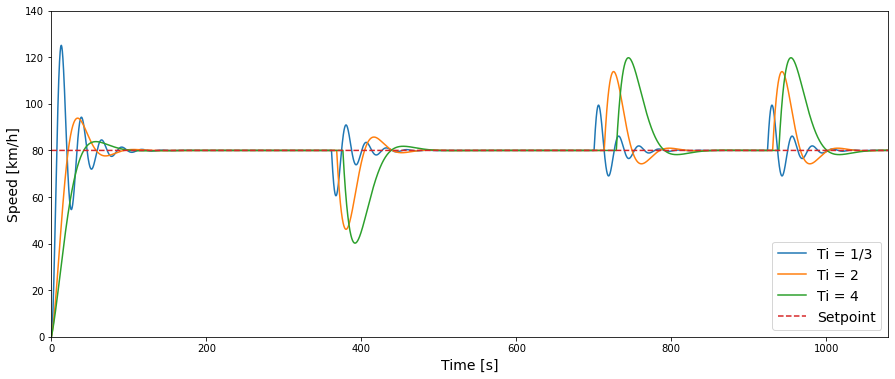

In [30]:
sim0 = simulation_result[simulation_result['subset'] == 0]
sim1 = simulation_result[simulation_result['subset'] == 1]
sim2 = simulation_result[simulation_result['subset'] == 2]

plt.figure(figsize=(15, 6))
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Speed [km/h]', fontsize=14)
plt.plot(sim0.timestep,sim0.speed*3.6, label="Ti = 1/3")
plt.plot(sim1.timestep,sim1.speed*3.6, label="Ti = 2")
plt.plot(sim2.timestep,sim2.speed*3.6, label="Ti = 4")
plt.plot(sim0.timestep, [80]*len(sim0), '--', label='Setpoint')
plt.legend(fontsize=14, loc='lower right')
plt.xlim([0,1080])
plt.ylim([0,140])

In [31]:
def plotar2(xvar, yvar, salvar, nomearq, xlim, ylim, xaxis_title, yaxis_title, ref):
    plt.figure(figsize=(15, 6))
    plt.xlabel(xaxis_title, fontsize=14)
    plt.ylabel(yaxis_title, fontsize=14)
    plt.grid(True)
    if ref:
        plt.plot(xvar, yvar, label='speed')
        plt.plot(xvar, [80]*len(xvar), '--', label='Setpoint')
        plt.legend(fontsize=14, loc='lower right')
    else:
        plt.plot(xvar, yvar)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    if salvar:
        plt.savefig(f'{nomearq}.eps', dpi=1200)
    plt.show()

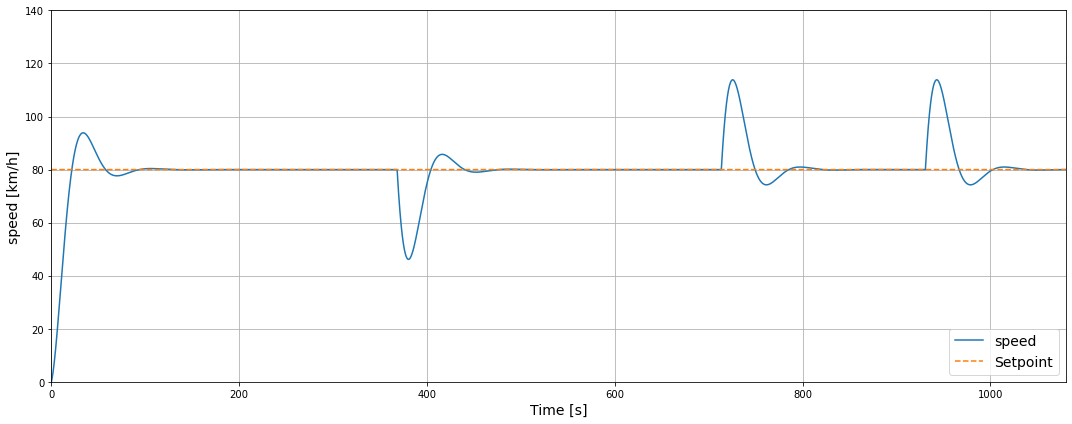

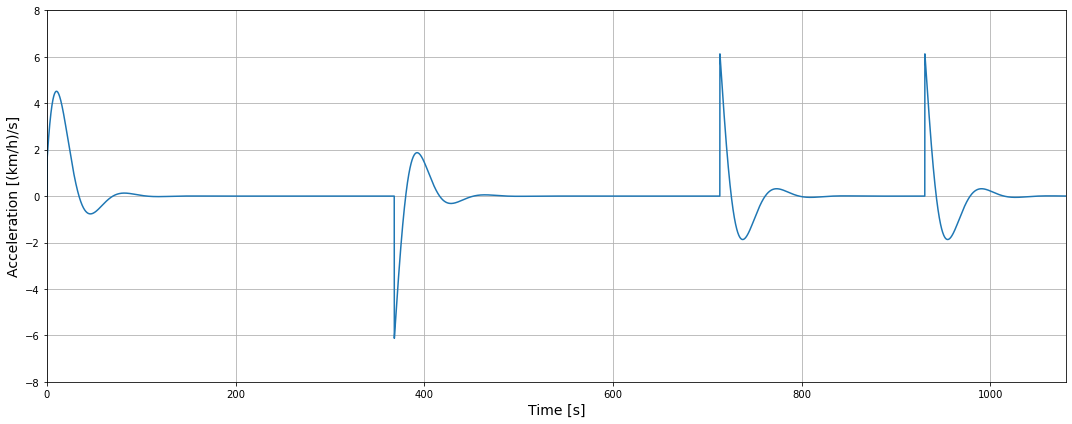

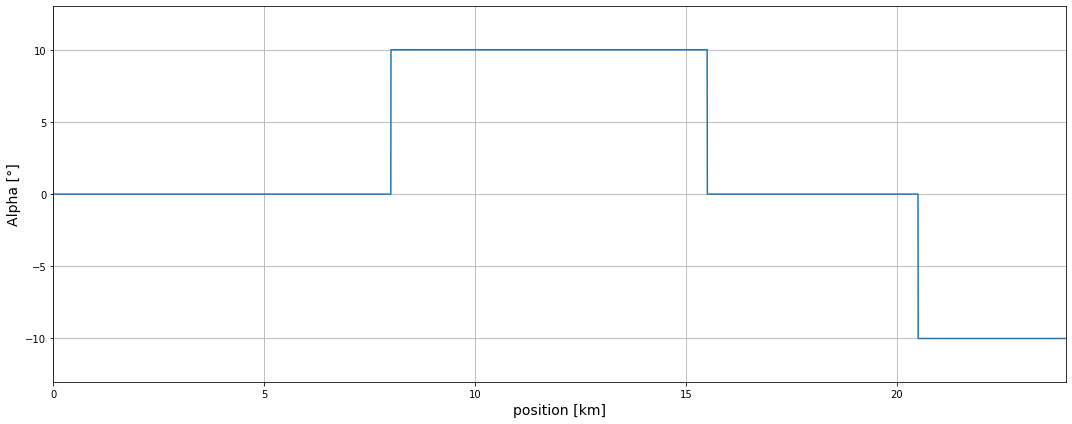

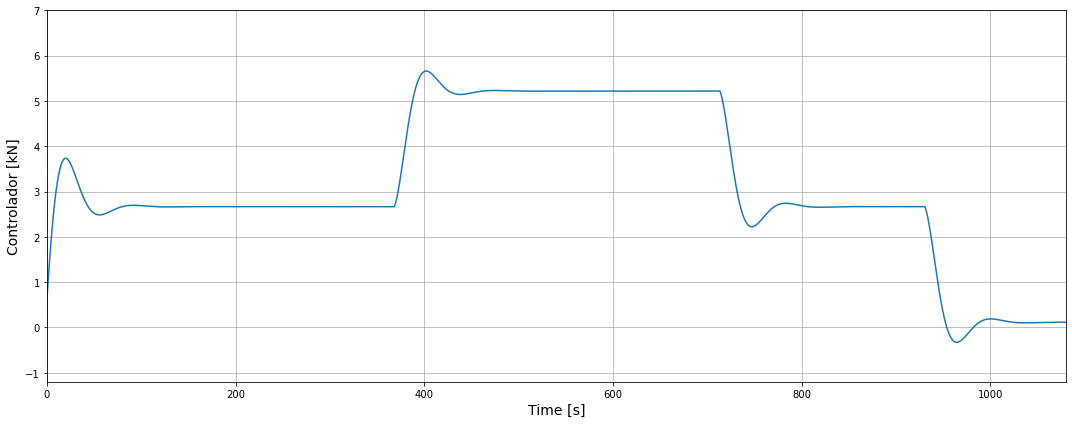

In [32]:
sim0 = simulation_result[simulation_result['subset'] == 1]

plotar2(sim0.timestep, sim0.speed*3.6, False, 'speedPI', [0, 1080],[0,140],"Time [s]","speed [km/h]", True)

#plotar2(sim0.timestep, sim0.position, False, 'positionPI',[0, 1080], [0,30],"Time [s]","Position [km]", False)

plotar2(sim0.timestep, sim0.acceleration*3.6, False, 'accelerationPI', [0, 1080],[-8,8],"Time [s]","Acceleration [(km/h)/s]", False)

plotar2(sim0.position, sim0.alpha, False, 'AlphaPI', [0,24],[-13,13],"position [km]",'''Alpha [°]''', False)

plotar2(sim0.timestep, sim0.PI/1000, False, 'ControladorPI', [0, 1080],[-1.2,7],"Time [s]","Controlador [kN]", False)